In this notebook we take the orthologous sequences and perform MSA for each gene (using clustal omega). Then, we "translate" the alignment from amino-acids to nucleotides (using pal2nal). 

In [1]:
import pandas as pd
import os
import pickle
import concurrent.futures
from os import listdir
from os.path import isfile, join
import numpy as np
import gzip
import shutil
import matplotlib.pyplot as plt


In [2]:
def write_ortholog_sequences_to_fasta_single_gene(gene:str) -> None:
    '''
    This function takes the orthologs' data that is stored in dictionaries downloaded
    from Ensembl using the REST API, and stores the aa and cdna sequences in fasta files
    (We need the input of clustal omega as fasta files). 
    '''
    try:
        '''Needed paths'''
        cdna_dict_path = f"../co_trans_data/orthologs/cdna_dict/cdna_{gene}.pickle" #a dict with the cdna sequences of the orthologs
        aa_dict_path = f"../co_trans_data/orthologs/aa_dict/aa_{gene}.pickle" #a dict with the aa sequences of the orthologs
        cdna_fasta_path = f"../co_trans_data/orthologs/nt_before_msa/{gene}.fasta" #where to write the fasta with the cdna sequences
        aa_fasta_path = f"../co_trans_data/orthologs/aa_before_msa/{gene}.fasta" #where to write the fasta with the aa sequences

        '''load the ortholog data dictionary'''
        cdna_dict = pickle.load(open(cdna_dict_path, "rb"))
        aa_dict = pickle.load(open(aa_dict_path, "rb"))

        '''write fastas'''
        #initilize files
        nt_file = open(cdna_fasta_path, "w")
        aa_file = open(aa_fasta_path, "w")
        #add the human sequence
        human_cdna_sequence = cdna_dict['data'][0]['homologies'][0]['source']['seq']
        human_aa_sequence = aa_dict['data'][0]['homologies'][0]['source']['seq']
        nt_file.write(f">0_homo_sapiens\n{human_cdna_sequence}\n")
        aa_file.write(f">0_homo_sapiens\n{human_aa_sequence}\n")
        #add the orthologous sequences
        num_orthologs = len(cdna_dict['data'][0]['homologies'])
        wanted_orthologs_counter = 1
        for cur_ortholog in range(num_orthologs):
            cdna_data = cdna_dict['data'][0]['homologies'][cur_ortholog]
            aa_data = aa_dict['data'][0]['homologies'][cur_ortholog]
            species_cdna = cdna_data ['target']['species']
            species_aa = aa_data ['target']['species']
            assert(species_cdna == species_aa)
            cdna_seq = cdna_data['target']['seq']
            aa_seq = aa_data['target']['seq']
            perc_id = cdna_dict['data'][0]['homologies'][cur_ortholog]['target']['perc_id'] #percent of the orthologous sequence that matches the human sequence
            if (len(cdna_seq) % 3 == 0) & (perc_id >= 50): #make sure that the sequence is a valid cds and that the identity is larger than 50
                nt_file.write(f">{wanted_orthologs_counter}_{species_cdna}\n{cdna_seq}\n")
                aa_file.write(f">{wanted_orthologs_counter}_{species_aa}\n{aa_seq}\n")
                wanted_orthologs_counter += 1
    except Exception as e:
        print(f"Could not perfrom this for gene {gene}: {e}")

In [3]:
'''Get the list of needed genes'''
genes_list = pd.read_pickle('../co_trans_data/unique_genes.pickle') #all protein-coding human genes


In [ ]:
'''Create the fasta files using parallel computing'''

with concurrent.futures.ProcessPoolExecutor(max_workers=60) as executor:
    futures = []
    for gene in genes_list:
        futures.append(executor.submit(write_ortholog_sequences_to_fasta_single_gene, gene=gene)) 

## Preform MSA using Clustal Omega

In [5]:
genes_list = pd.read_pickle('../co_trans_data/genes_for_msa.pickle') #only genes with orthologs

In [3]:
'''use clustal omega [www.clustal.org] to perform the MSA'''

def perform_msa(gene:str) -> None:
    '''
    This function calls Clustal Omega [www.clustal.org] from the CLI,
    to perform the MSA on the amino acid orthologous sequences of a gene
    '''
    input_path = f'../co_trans_data/orthologs/aa_before_msa/{gene}.fasta'
    output_path = f'../co_trans_data/orthologs/aa_after_msa/{gene}.fasta'
    !clustalo -i $input_path -o $output_path #call clustal omega from the cli 

In [ ]:
'''Create the MSAs using parallel computing'''

with concurrent.futures.ProcessPoolExecutor(max_workers=50) as executor:
    futures = []
    for gene in genes_list:
        futures.append(executor.submit(perform_msa, gene=gene)) 

## Change MSA from amino-acids to nucleotides

In [8]:
genes_list = pd.read_pickle('../co_trans_data/genes_for_msa.pickle') #only genes with orthologs

In [9]:
'''Create batches of genes for parallalization'''
num_wanted_cpus = 50
num_genes = len(genes_list)
num_genes_per_batch = int(np.round(num_genes /num_wanted_cpus))
batches_of_genes = [genes_list[x:x+num_genes_per_batch] for x in range(0, num_genes, num_genes_per_batch)]
#change the gene names in each batch to strings to fit the bash code
batches_of_genes_string = []
for batch in batches_of_genes:
    batch = ":".join(batch)
    batches_of_genes_string.append(batch)

Note: pal2nal prints many warnings while running and there is no option to control the verbosity. 
This makes the notebook crash. So, instead of calling the cpus in parellel directly from the notebook as we did with clustalo, we will create a bash script that calls pal2nal from the cli. 

In [10]:
%%writefile run_pal2nal.sh
#!/bin/bash

cd ./co_trans_code/

eval "$(conda shell.bash hook)"
conda activate co-trans

cur_batch=$(echo $single_batch_of_genes|sed 's/:/ /g')

for gene in $cur_batch;
do
aa_path=$aa_after_msa_path$gene
nt_before_path=$nt_before_msa_path$gene
nt_after_path=$output_path$gene

pal2nal.pl "${aa_path}.fasta" "${nt_before_path}.fasta" -output fasta > "${nt_after_path}.fasta"
done


Overwriting run_pal2nal.sh


## How many orthologs per gene?

In [25]:
directory = "../co_trans_data/orthologs/aa_before_msa/"

num_orthologs = []
for filename in os.listdir(directory):
    
    #unzip
    with gzip.open(f"{directory}{filename}", 'rb') as f_in:
        not_zipped_filename = ".".join(filename.split(".")[:-1])
        with open(f"./{not_zipped_filename}_aa_before", 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            
    #count orthologs per gene
    num = len([1 for line in open(f"./{not_zipped_filename}_aa_before") if line.startswith(">")])
    num_orthologs.append(num)
    os.remove(f"./{not_zipped_filename}_aa_before")

Text(0.5, 1.0, 'Number of orthologs per gene')

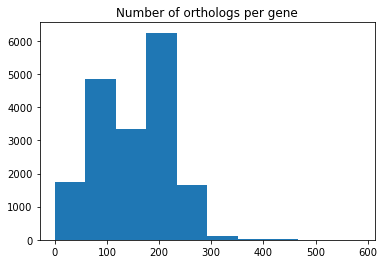

In [28]:
plt.hist(num_orthologs)
plt.title("Number of orthologs per gene")



In [29]:
np.mean(num_orthologs)

149.9347705300589

In [30]:
np.median(num_orthologs)

155.0